In [197]:
import torch
from torch.nn import functional as F
from torch import nn, optim
from math import sqrt

In [198]:
class EqualLR:
    def __init__(self, name):
        self.name = name

    def compute_weight(self, module):
        weight = getattr(module, self.name + '_orig')
        fan_in = weight.data.size(1) * weight.data[0][0].numel()

        return weight * sqrt(2 / fan_in)

    @staticmethod
    def apply(module, name):
        fn = EqualLR(name)

        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        module.register_forward_pre_hook(fn)

        return fn

    def __call__(self, module, input):
        weight = self.compute_weight(module)
        setattr(module, self.name, weight)

In [199]:
def equal_lr(module, name='weight'):
    EqualLR.apply(module, name)

    return module

In [200]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input / torch.sqrt(torch.mean(input ** 2, dim=1, keepdim=True)
                                  + 1e-8)

In [201]:
class EqualConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)

In [202]:
class EqualConvTranspose2d(nn.Module):
    ### additional module for OOGAN usage
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.ConvTranspose2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)

In [203]:
class EqualLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        linear = nn.Linear(in_dim, out_dim)
        linear.weight.data.normal_()
        linear.bias.data.zero_()

        self.linear = equal_lr(linear)

    def forward(self, input):
        return self.linear(input)

In [204]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, padding, kernel_size2=None, padding2=None, pixel_norm=True):
        super().__init__()

        pad1 = padding
        pad2 = padding
        if padding2 is not None:
            pad2 = padding2

        kernel1 = kernel_size
        kernel2 = kernel_size
        if kernel_size2 is not None:
            kernel2 = kernel_size2

        convs = [EqualConv2d(in_channel, out_channel, kernel1, padding=pad1)]
        if pixel_norm:
            convs.append(PixelNorm())
        convs.append(nn.LeakyReLU(0.1))
        convs.append(EqualConv2d(out_channel, out_channel, kernel2, padding=pad2))
        if pixel_norm:
            convs.append(PixelNorm())
        convs.append(nn.LeakyReLU(0.1))

        self.conv = nn.Sequential(*convs)

    def forward(self, input):
        out = self.conv(input)
        return out


In [205]:
def upscale(feat):
    return F.interpolate(feat, scale_factor=2, mode='bilinear', align_corners=False)

In [206]:
class Generator(nn.Module):
    def __init__(self, input_code_dim=128, in_channel=128, pixel_norm=True, tanh=True):
        super().__init__()
        self.input_dim = input_code_dim
        self.tanh = tanh
        self.input_layer = nn.Sequential(
            EqualConvTranspose2d(input_code_dim, in_channel, 4, 1, 0),
            PixelNorm(),
            nn.LeakyReLU(0.1))

        self.progression_4 = ConvBlock(in_channel, in_channel, 3, 1, pixel_norm=pixel_norm)
        self.progression_8 = ConvBlock(in_channel, in_channel, 3, 1, pixel_norm=pixel_norm)
        self.progression_16 = ConvBlock(in_channel, in_channel, 3, 1, pixel_norm=pixel_norm)
        self.progression_32 = ConvBlock(in_channel, in_channel, 3, 1, pixel_norm=pixel_norm)
        self.progression_64 = ConvBlock(in_channel, in_channel//2, 3, 1, pixel_norm=pixel_norm)
        self.progression_128 = ConvBlock(in_channel//2, in_channel//4, 3, 1, pixel_norm=pixel_norm)
        self.progression_256 = ConvBlock(in_channel//4, in_channel//4, 3, 1, pixel_norm=pixel_norm)

        self.to_rgb_8 = EqualConv2d(in_channel, 3, 1)
        self.to_rgb_16 = EqualConv2d(in_channel, 3, 1)
        self.to_rgb_32 = EqualConv2d(in_channel, 3, 1)
        self.to_rgb_64 = EqualConv2d(in_channel//2, 3, 1)
        self.to_rgb_128 = EqualConv2d(in_channel//4, 3, 1)
        self.to_rgb_256 = EqualConv2d(in_channel//4, 3, 1)
        
        self.max_step = 6

    def progress(self, feat, module):
        out = F.interpolate(feat, scale_factor=2, mode='bilinear', align_corners=False)
        out = module(out)
        return out

    def output(self, feat1, feat2, module1, module2, alpha):
        if 0 <= alpha < 1:
            skip_rgb = upscale(module1(feat1))
            out = (1-alpha)*skip_rgb + alpha*module2(feat2)
        else:
            out = module2(feat2)
        if self.tanh:
            return torch.tanh(out)
        return out

    def forward(self, input, step=0, alpha=-1):
        if step > self.max_step:
            step = self.max_step

        out_4 = self.input_layer(input.view(-1, self.input_dim, 1, 1))
        out_4 = self.progression_4(out_4)
        out_8 = self.progress(out_4, self.progression_8)
        if step==1:
            if self.tanh:
                return torch.tanh(self.to_rgb_8(out_8))
            return self.to_rgb_8(out_8)
        
        out_16 = self.progress(out_8, self.progression_16)
        if step==2:
            return self.output( out_8, out_16, self.to_rgb_8, self.to_rgb_16, alpha )
        
        out_32 = self.progress(out_16, self.progression_32)
        if step==3:
            return self.output( out_16, out_32, self.to_rgb_16, self.to_rgb_32, alpha )

        out_64 = self.progress(out_32, self.progression_64)
        if step==4:
            return self.output( out_32, out_64, self.to_rgb_32, self.to_rgb_64, alpha )
        
        out_128 = self.progress(out_64, self.progression_128)
        if step==5:
            return self.output( out_64, out_128, self.to_rgb_64, self.to_rgb_128, alpha )

        out_256 = self.progress(out_128, self.progression_256)
        if step==6:
            return self.output( out_128, out_256, self.to_rgb_128, self.to_rgb_256, alpha )

In [207]:
class Discriminator(nn.Module):
    def __init__(self, feat_dim=128):
        super().__init__()

        self.progression = nn.ModuleList([ConvBlock(feat_dim//4, feat_dim//4, 3, 1),
                                          ConvBlock(feat_dim//4, feat_dim//2, 3, 1),
                                          ConvBlock(feat_dim//2, feat_dim, 3, 1),
                                          ConvBlock(feat_dim, feat_dim, 3, 1),
                                          ConvBlock(feat_dim, feat_dim, 3, 1),
                                          ConvBlock(feat_dim, feat_dim, 3, 1),
                                          ConvBlock(feat_dim+1, feat_dim, 3, 1, 4, 0)])

        self.from_rgb = nn.ModuleList([EqualConv2d(3, feat_dim//4, 1),
                                       EqualConv2d(3, feat_dim//4, 1),
                                       EqualConv2d(3, feat_dim//2, 1),
                                       EqualConv2d(3, feat_dim, 1),
                                       EqualConv2d(3, feat_dim, 1),
                                       EqualConv2d(3, feat_dim, 1),
                                       EqualConv2d(3, feat_dim, 1)])

        self.n_layer = len(self.progression)

        self.linear = EqualLinear(feat_dim, 1)

    def forward(self, input, step=0, alpha=-1):
        for i in range(step, -1, -1):
            index = self.n_layer - i - 1

            if i == step:
                out = self.from_rgb[index](input)

            if i == 0:
                out_std = torch.sqrt(out.var(0, unbiased=False) + 1e-8)
                mean_std = out_std.mean()
                mean_std = mean_std.expand(out.size(0), 1, 4, 4)
                out = torch.cat([out, mean_std], 1)

            out = self.progression[index](out)

            if i > 0:
                # out = F.avg_pool2d(out, 2)
                out = F.interpolate(out, scale_factor=0.5, mode='bilinear', align_corners=False)

                if i == step and 0 <= alpha < 1:
                    # skip_rgb = F.avg_pool2d(input, 2)
                    skip_rgb = F.interpolate(input, scale_factor=0.5, mode='bilinear', align_corners=False)
                    skip_rgb = self.from_rgb[index + 1](skip_rgb)
                    out = (1 - alpha) * skip_rgb + alpha * out

        out = out.squeeze(2).squeeze(2)
        # print(input.size(), out.size(), step)
        out = self.linear(out)

        return out

In [208]:
def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())
    
    for k in par1.keys():
        par1[k].data.mul_(decay).add_(1 - decay, par2[k].data)

In [209]:
class Args_wrapper:
    def __init__(self):
        self.path = "../data/celebb"
        self.trial_name = "progressive_gans"
        self.z_dim = 100
        self.channel = 512
        self.batch_size = 4
        self.init_step = 2
        self.total_iter = 100000
        self.pixel_norm=True
        self.tanh=True
        self.gpu_id=2
        self.lr=0.001
        self.n_critic=1
        self.init_step=1
               
args = Args_wrapper()

In [210]:
print(str(args))

trial_name = args.trial_name

device = torch.device("cuda:%d"%(args.gpu_id))

input_code_size = args.z_dim
batch_size = args.batch_size
n_critic = args.n_critic

generator = Generator(in_channel=args.channel, input_code_dim=input_code_size, pixel_norm=args.pixel_norm, tanh=args.tanh)
#generator = nn.DataParallel(generator, list(range(ngpu)))

In [211]:
discriminator = Discriminator(feat_dim=args.channel)

In [212]:
g_running = Generator(in_channel=args.channel, input_code_dim=input_code_size, pixel_norm=args.pixel_norm, tanh=args.tanh).to(device)

In [213]:
g_optimizer = optim.Adam(generator.parameters(), lr=args.lr, betas=(0.0, 0.99))
d_optimizer = optim.Adam(discriminator.parameters(), lr=args.lr, betas=(0.0, 0.99))

In [214]:
G_PATH = "/home/misthios/Documents/d2l-fanbyprinciple/testing/trial_progressive_gans_2022-04-20_15_8/checkpoint/150000_g.model"
D_PATH = "/home/misthios/Documents/d2l-fanbyprinciple/testing/trial_progressive_gans_2022-04-20_15_8/checkpoint/150000_d.model"

In [215]:
G_checkpoint = torch.load(G_PATH)
D_checkpoint = torch.load(D_PATH)

In [216]:
G_checkpoint.keys()

odict_keys(['input_layer.0.conv.bias', 'input_layer.0.conv.weight_orig', 'progression_4.conv.0.conv.bias', 'progression_4.conv.0.conv.weight_orig', 'progression_4.conv.3.conv.bias', 'progression_4.conv.3.conv.weight_orig', 'progression_8.conv.0.conv.bias', 'progression_8.conv.0.conv.weight_orig', 'progression_8.conv.3.conv.bias', 'progression_8.conv.3.conv.weight_orig', 'progression_16.conv.0.conv.bias', 'progression_16.conv.0.conv.weight_orig', 'progression_16.conv.3.conv.bias', 'progression_16.conv.3.conv.weight_orig', 'progression_32.conv.0.conv.bias', 'progression_32.conv.0.conv.weight_orig', 'progression_32.conv.3.conv.bias', 'progression_32.conv.3.conv.weight_orig', 'progression_64.conv.0.conv.bias', 'progression_64.conv.0.conv.weight_orig', 'progression_64.conv.3.conv.bias', 'progression_64.conv.3.conv.weight_orig', 'progression_128.conv.0.conv.bias', 'progression_128.conv.0.conv.weight_orig', 'progression_128.conv.3.conv.bias', 'progression_128.conv.3.conv.weight_orig', 'progre

In [217]:
g_running.load_state_dict(G_checkpoint)

<All keys matched successfully>

In [218]:
discriminator.load_state_dict(D_checkpoint)

<All keys matched successfully>

In [219]:
torch.randn(50, input_code_size)

tensor([[-1.8784, -2.1372, -0.5575,  ...,  0.5112,  0.4631, -0.6862],
        [ 0.2292, -1.1222,  0.2686,  ...,  1.8446, -0.1479, -0.2290],
        [-0.5751, -1.1901,  0.3560,  ...,  1.0936,  0.0292, -0.2377],
        ...,
        [ 1.1955,  0.8432, -0.2938,  ..., -1.7986,  0.1316,  0.7277],
        [-0.6199, -0.9528,  1.0585,  ...,  1.1389,  0.4161,  0.6267],
        [-0.5158, -0.7683, -0.3314,  ...,  0.3381,  0.3096,  1.3006]])

In [220]:
from torchvision import datasets, transforms, utils

In [241]:
# generating images from GAN

# with torch.no_grad():
#     for i in range(1,20):
#         for j in range(1,10):
#             well = g_running(torch.randn(5*10, input_code_size).to(device),step=i, alpha=j)
#             images = well.data.cpu()
   
#             utils.save_image(images,f'sample/output_{j}_{i}.png',nrow=10,normalize=True,range=(-1, 1))

In [245]:
# step value 3 gives the best result

In [244]:
# with torch.no_grad():
#     for i in range(1,10):
#         well = g_running(torch.randn(5*10, input_code_size).to(device),step=3, alpha=i)
#         images = well.data.cpu()
   
#         utils.save_image(images,f'sample/output_{i}.png',nrow=10,normalize=True,range=(-1, 1))

KeyboardInterrupt: 

In [246]:
with torch.no_grad():
#     for i in range(1,10):
    well = g_running(torch.randn(5*10, input_code_size).to(device),step=3, alpha=i)
    images = well.data.cpu()

In [247]:
images.shape

torch.Size([50, 3, 32, 32])

In [248]:
import matplotlib.pyplot as plt
import random
import cv2
from PIL import Image

import torch 
import torchvision 
import torchvision.transforms as T 
from PIL import Image

In [249]:
image = images[random.choice(range(len(images)))].permute(1,2,0)
image.shape

torch.Size([32, 32, 3])

In [250]:
image

tensor([[[ 0.0156, -0.2112, -0.3759],
         [ 0.0895, -0.1691, -0.3914],
         [-0.5702, -0.6419, -0.7592],
         ...,
         [-0.3253, -0.4405, -0.5099],
         [-0.2742, -0.3728, -0.4510],
         [-0.1318, -0.2351, -0.2989]],

        [[-0.0330, -0.3007, -0.4236],
         [-0.2483, -0.4801, -0.6211],
         [-0.5294, -0.6058, -0.7089],
         ...,
         [-0.5434, -0.6339, -0.6943],
         [-0.3003, -0.3604, -0.4234],
         [-0.1359, -0.2753, -0.3250]],

        [[-0.1035, -0.3875, -0.5449],
         [-0.1254, -0.4039, -0.5814],
         [-0.2942, -0.4267, -0.5911],
         ...,
         [-0.6393, -0.7245, -0.7837],
         [-0.4455, -0.5094, -0.5754],
         [-0.1433, -0.2728, -0.3267]],

        ...,

        [[ 0.6864,  0.5594,  0.2264],
         [ 0.6495,  0.5185,  0.1407],
         [ 0.6300,  0.4927,  0.1050],
         ...,
         [ 0.3558,  0.2598,  0.2063],
         [ 0.4241,  0.3721,  0.3538],
         [ 0.4851,  0.4202,  0.4064]],

        [[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


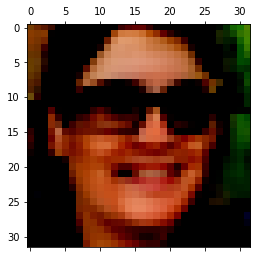

In [264]:
image = images[random.choice(range(len(images)))].permute(1,2,0)
plt.matshow(image * 1)
plt.show()

In [252]:
transform = T.ToPILImage()

In [253]:
img = transform(images[random.choice(range(len(images)))])

In [229]:
#img.show()

In [230]:
## openning a normal image
im = Image.open(r"gan.png") 
  
# This method will show image in any image viewer 
#im.show() 

In [231]:
transform = T.Compose([T.PILToTensor()])

tensor = transform(img)

In [232]:
tensor

tensor([[[184,  91,  81,  ..., 170, 158, 181],
         [107,  52,  36,  ...,  58,  72,  70],
         [113,  51,  25,  ...,  24,  36,  33],
         ...,
         [ 61,  35,  59,  ..., 145,   7, 234],
         [ 41,  39,  47,  ..., 108, 228, 206],
         [ 30,  22,  33,  ..., 100, 203, 232]],

        [[108, 115,  78,  ..., 223, 227, 198],
         [103, 117, 105,  ..., 193, 166, 155],
         [101, 108, 102,  ..., 141, 114, 116],
         ...,
         [ 66,  47,  44,  ...,  62,  78,  58],
         [ 52,  41,  46,  ...,  35,  69,  47],
         [ 37,  44,  88,  ...,  30,  42,  49]],

        [[ 41,  23,  21,  ...,  59, 122, 235],
         [ 26,  24,  25,  ...,  69, 136, 177],
         [ 48,  63,  86,  ...,  63, 112, 145],
         ...,
         [ 55,   4,  43,  ..., 246, 191, 117],
         [ 40, 226, 252,  ..., 184, 181,  92],
         [ 85,  39,  18,  ..., 119,  79,  55]]], dtype=torch.uint8)

In [233]:
# this for training models

# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()
# # - or -
# model.train()